In [1]:
!pip install numpy==1.23.5

In [1]:
from sklearn.preprocessing import StandardScaler
import pyupbit
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import shap

In [2]:
class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x

In [22]:
# 데이터 로드
ticker = 'KRW-BTC'
interval = 'minute5'
to = '2024-10-31 09:00'
count = 8064
data = pyupbit.get_ohlcv(ticker=ticker, interval=interval, to=to, count=count)
# 이동평균 3과 5 계산
data['ma_3'] = data['close'].rolling(window=3).mean()  # 3-period 이동평균
data['ma_5'] = data['close'].rolling(window=5).mean()  # 5-period 이동평균
data['middle'] = (data['high'] + data['low']) / 2


#1달 데이터 3분간격

In [23]:
# NaN 값 제거 (초기 구간에서는 이동평균 계산 불가)
data = data.dropna()

In [24]:
data

,open,high,low,close,volume,value,ma_3,ma_5,middle
2024-10-03 12:50:00,82588000.0,82610000.0,82540000.0,82608000.0,3.097142,2.558176e+08,8.256567e+07,82557800.0,82575000.0
2024-10-03 12:55:00,82580000.0,82700000.0,82580000.0,82700000.0,5.252914,4.341753e+08,8.263267e+07,82574400.0,82640000.0
2024-10-03 13:00:00,82700000.0,82700000.0,82601000.0,82698000.0,4.282307,3.540157e+08,8.266867e+07,82619000.0,82650500.0
2024-10-03 13:05:00,82696000.0,82698000.0,82608000.0,82615000.0,2.353429,1.945350e+08,8.267100e+07,82642200.0,82653000.0
2024-10-03 13:10:00,82642000.0,82642000.0,82590000.0,82601000.0,5.251485,4.338547e+08,8.263800e+07,82644400.0,82616000.0
...,...,...,...,...,...,...,...,...,...
2024-10-31 17:35:00,100426000.0,100450000.0,100372000.0,100448000.0,5.674975,5.698675e+08,1.004567e+08,100484400.0,100411000.0
2024-10-31 17:40:00,100448000.0,100448000.0,100400000.0,100419000.0,3.875981,3.892287e+08,1.004313e+08,100457000.0,100424000.0
2024-10-31 17:45:00,100419000.0,100454000.0,100402000.0,100433000.0,3.649236,3.664602e+08,1.004333e+08,100444400.0,100428000.0
2024-10-31 17:50:00,100433000.0,100488000.0,100401000.0,100480000.0,3.390553,3.405635e+08,1.004440e+08,100441400.0,100444500.0


In [25]:
# 데이터 분리
SPLIT = int(0.7 * len(data))  # 7:3으로 분할
train_data = data[:SPLIT]
test_data = data[SPLIT:]

In [26]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
revin = RevIN(num_features=9, affine=True).to(DEVICE)  # num_features는 feature의 개수


In [27]:
# 데이터를 Tensor로 변환
train_tensor = torch.FloatTensor(train_data.values).to(DEVICE)
test_tensor = torch.FloatTensor(test_data.values).to(DEVICE)

# RevIN 정규화
train_normalized = revin(train_tensor, mode='norm')
test_normalized = revin(test_tensor, mode='norm')


In [28]:
print(train_normalized)
print(test_normalized)

tensor([[-0.1586, -0.1586, -0.1587,  ..., -0.1587, -0.1587, -0.1587],
        [-0.1586, -0.1583, -0.1586,  ..., -0.1585, -0.1587, -0.1585],
        [-0.1583, -0.1583, -0.1586,  ..., -0.1584, -0.1585, -0.1585],
        ...,
        [-0.1323, -0.1323, -0.1326,  ..., -0.1323, -0.1321, -0.1325],
        [-0.1326, -0.1323, -0.1326,  ..., -0.1324, -0.1322, -0.1325],
        [-0.1324, -0.1322, -0.1324,  ..., -0.1324, -0.1323, -0.1323]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([[-0.1748, -0.1748, -0.1750,  ..., -0.1749, -0.1749, -0.1749],
        [-0.1750, -0.1749, -0.1750,  ..., -0.1749, -0.1750, -0.1750],
        [-0.1750, -0.1750, -0.1751,  ..., -0.1750, -0.1750, -0.1751],
        ...,
        [-0.1602, -0.1601, -0.1602,  ..., -0.1602, -0.1601, -0.1602],
        [-0.1602, -0.1600, -0.1602,  ..., -0.1601, -0.1601, -0.1601],
        [-0.1601, -0.1599, -0.1601,  ..., -0.1600, -0.1601, -0.1600]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [29]:
#데이터 분리
def MakeSeqNumpyData(data, seq_length):
    x_seq_list = []
    y_seq_list = []
    for i in range(len(data) - seq_length):
        x_seq_list.append(data[i:i + seq_length, :-1])  # 입력 데이터
        y_seq_list.append(data[i + seq_length, [-1]])  # 정답 데이터
    return np.array(x_seq_list), np.array(y_seq_list)

SEQ_LENGTH = 288  # 시퀀스 길이
x_train_data, y_train_data = MakeSeqNumpyData(train_normalized.detach().cpu().numpy(), SEQ_LENGTH)
x_test_data, y_test_data = MakeSeqNumpyData(test_normalized.detach().cpu().numpy(), SEQ_LENGTH)


In [30]:
print(x_train_data)
print(y_train_data)
print(x_test_data)
print(y_test_data)

[[[-0.158624   -0.1585687  -0.15874462 ...  0.27670833 -0.15868011
   -0.15869989]
  [-0.1586441  -0.15834253 -0.1586441  ...  0.7249274  -0.15851174
   -0.15865816]
  [-0.15834253 -0.15834253 -0.15859132 ...  0.5234835  -0.15842128
   -0.15854609]
  ...
  [-0.15920952 -0.15910146 -0.15926984 ...  0.25074092 -0.15915424
   -0.15912609]
  [-0.15910146 -0.15903361 -0.1591065  ...  0.0443552  -0.15912324
   -0.15909845]
  [-0.15905875 -0.15903361 -0.15919696 ...  0.12297177 -0.159078
   -0.15911905]]

 [[-0.1586441  -0.15834253 -0.1586441  ...  0.7249274  -0.15851174
   -0.15865816]
  [-0.15834253 -0.15834253 -0.15859132 ...  0.5234835  -0.15842128
   -0.15854609]
  [-0.15835258 -0.15834755 -0.15857373 ...  0.1227027  -0.1584154
   -0.15848778]
  ...
  [-0.15910146 -0.15903361 -0.1591065  ...  0.0443552  -0.15912324
   -0.15909845]
  [-0.15905875 -0.15903361 -0.15919696 ...  0.12297177 -0.159078
   -0.15911905]
  [-0.15907381 -0.15884514 -0.15911905 ...  0.17180565 -0.15901436
   -0.15907

In [31]:
#텐서로 변환
x_train_tensor = torch.FloatTensor(x_train_data).to(DEVICE)
y_train_tensor = torch.FloatTensor(y_train_data).to(DEVICE)
x_test_tensor = torch.FloatTensor(x_test_data).to(DEVICE)
y_test_tensor = torch.FloatTensor(y_test_data).to(DEVICE)

# DataLoader 생성
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

BATCH_SIZE = 20
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [32]:
#GRU 모델
class MyGRUModel(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)  # GRU 사용
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, data):
        h0 = torch.zeros(self.num_layers, data.size(0), self.hidden_size).to(DEVICE)
        
        outputs, _ = self.gru(data, h0)  # GRU는 h0만 초기화
        last_hs = outputs[:, -1, :]
        prediction = self.fc(last_hs)
        
        return prediction


FEATURE_NUMS = 8  # 입력 feature 수
HIDDEN_SIZE = 4   # LSTM hidden state 크기
NUM_LAYERS = 1    # LSTM 층 수

model = MyGRUModel(FEATURE_NUMS, HIDDEN_SIZE, NUM_LAYERS).to(DEVICE)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [33]:
#모델 훈련
def model_train(dataloader, model, loss_function, optimizer):
    model.train()
    total_loss = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

EPOCHS = 200
train_loss_list = []

for epoch in range(EPOCHS):
    avg_loss = model_train(train_loader, model, loss_function, optimizer)
    train_loss_list.append(avg_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}]")


Epoch [10/200]
Epoch [20/200]
Epoch [30/200]
Epoch [40/200]
Epoch [50/200]
Epoch [60/200]
Epoch [70/200]
Epoch [80/200]
Epoch [90/200]
Epoch [100/200]
Epoch [110/200]
Epoch [120/200]
Epoch [130/200]
Epoch [140/200]
Epoch [150/200]
Epoch [160/200]
Epoch [170/200]
Epoch [180/200]
Epoch [190/200]
Epoch [200/200]


In [34]:
# 테스트 예측
test_pred_tensor = model(x_test_tensor)

# 역정규화
test_pred_denormalized = revin(test_pred_tensor, mode='denorm')
y_test_denormalized = revin(y_test_tensor, mode='denorm')

# NumPy 변환
test_pred_numpy = test_pred_denormalized.cpu().detach().numpy()
y_test_numpy = y_test_denormalized.cpu().detach().numpy()


In [35]:
y_test_numpy

array([[9.233250e+07, 9.233250e+07, 9.233250e+07, ..., 9.233250e+07,
        9.233250e+07, 9.233250e+07],
       [9.234550e+07, 9.234550e+07, 9.234550e+07, ..., 9.234550e+07,
        9.234550e+07, 9.234550e+07],
       [9.240900e+07, 9.240900e+07, 9.240900e+07, ..., 9.240900e+07,
        9.240900e+07, 9.240900e+07],
       ...,
       [1.004280e+08, 1.004280e+08, 1.004280e+08, ..., 1.004280e+08,
        1.004280e+08, 1.004280e+08],
       [1.004445e+08, 1.004445e+08, 1.004445e+08, ..., 1.004445e+08,
        1.004445e+08, 1.004445e+08],
       [1.005240e+08, 1.005240e+08, 1.005240e+08, ..., 1.005240e+08,
        1.005240e+08, 1.005240e+08]], dtype=float32)

In [36]:
Pred_end = test_pred_numpy[:,-1]
Test_end = y_test_numpy[:, -1]

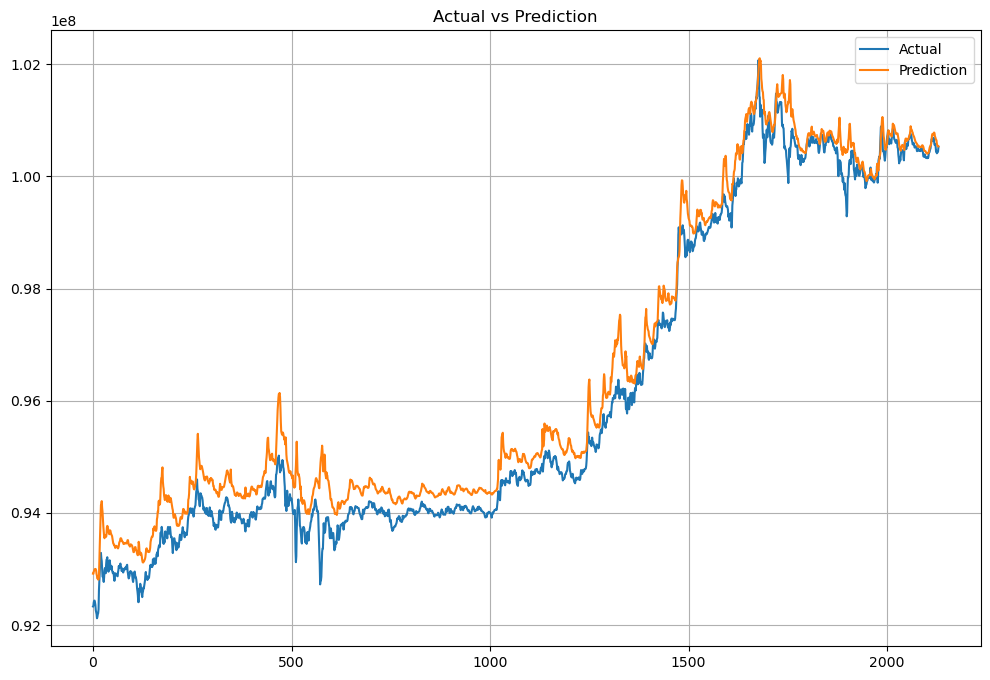

In [37]:
plt.figure(figsize=(12, 8))
plt.plot(Test_end, label='Actual')
plt.plot(Pred_end, label='Prediction')
plt.title('Actual vs Prediction')
plt.grid()
plt.legend()
plt.show()


In [38]:
def calculate_metrics(pred, true):
    """
    MAE, MSE, RMSE, MAPE, MSPE 계산
    :param pred: 예측값 (1D array)
    :param true: 실제값 (1D array)
    :return: 각 지표의 값
    """
    mae = np.mean(np.abs(pred - true))  # Mean Absolute Error
    mse = np.mean((pred - true) ** 2)  # Mean Squared Error
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    mape = np.mean(np.abs((true - pred) / true)) * 100  # Mean Absolute Percentage Error
    mspe = np.mean(((true - pred) / true) ** 2) * 100  # Mean Squared Percentage Error

    return mae, mse, rmse, mape, mspe


In [39]:
# 마지막 피처 값만 추출
pred_values = test_pred_numpy[:, -1]
true_values = y_test_numpy[:, -1]

# 평가 지표 계산
mae, mse, rmse, mape, mspe = calculate_metrics(pred_values, true_values)

# 결과 출력
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"MSPE: {mspe:.4f}%")


MAE: 412538.1562
MSE: 234274471936.0000
RMSE: 484019.0938
MAPE: 0.43%
MSPE: 0.0026%


In [40]:
start_idx = 0
end_idx = 500
pred_subset = Pred_end[start_idx:end_idx]
y_test_subset = Test_end[start_idx:end_idx]

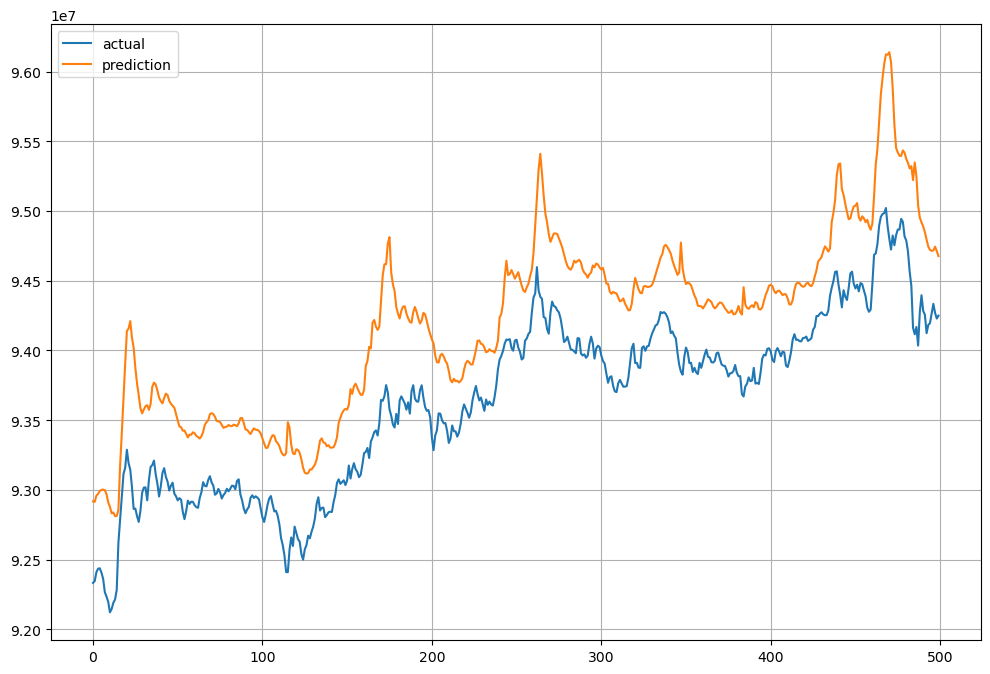

In [41]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_subset, label='actual')
plt.plot(pred_subset, label='prediction')
plt.grid()
plt.legend()

In [42]:
start_idx = 1500
end_idx = 2000
pred_subset = Pred_end[start_idx:end_idx]
y_test_subset = Test_end[start_idx:end_idx]

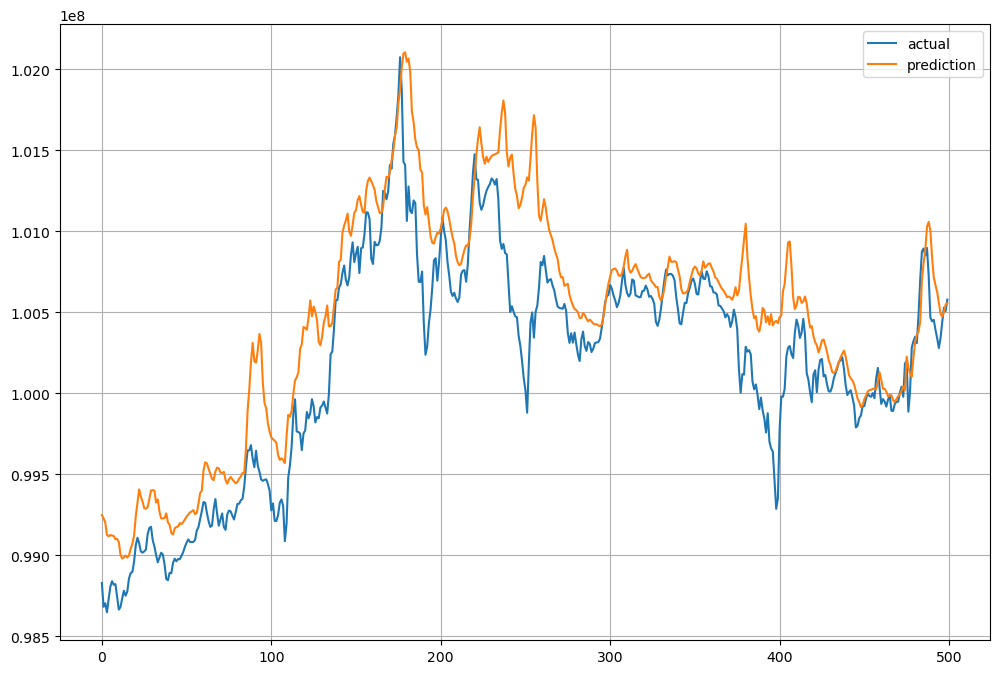

In [43]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_subset, label='actual')
plt.plot(pred_subset, label='prediction')
plt.grid()
plt.legend()